## Part A. Working with Biological Text Data

### Loading a dataset from TSV or CSV files
This package is intended to work with a data table where each row corresponds to a particular gene or protein, and additional information in the form of natural language and free text or ontology term annotations are present as well. Specifically, this package can work with pandas dataframes objects that are formatted to containa the following columns:
* **species**: a string indicating the species this gene belongs to
* **gene_names**: a bar-delimited list of gene names, acccessions, or identifiers
* **description**: a string of any text information related to this gene
* **term_ids**: a bar-delimited list of ontology term IDs associated with this gene

This information can be read from a TSV or CSV file or any other source, as long as it can be loaded into a pandas dataframe with that format. Once in a dataframe, this data can be added to a `Dataset` object specific to this package, which has useful wrapper functions for filtering the data, subsetting the data, adding additional data, merging based on gene names, and accessing the data. Once data has been loaded into the `Dataset` object, each entry is assigned a particular ID value which is maintained as an internal reference. Additional data can always be loaded using the **add_data** method. If multiple entries that represent the same genes are likely to have been loaded into the dataset when multiple sources are provided, the method `collapse_by_all_gene_names` can be used to merge entries that have atleast one of the same provided gene names. This method should only be used when the strings present in the gene names field are unique identifiers.

* `add_data()`: add a pandas dataframe formatted as described above to the dataset
* `collapse_by_all_gene_names()`: merge entries in the dataset that reference the same gene


In [1]:
# Importing other python modules used in this notebook.
import pandas as pd
import numpy as np
import pprint
import sys
import gensim
import warnings
warnings.simplefilter('ignore')

# Importing submodules from this package used in this notebook.
sys.path.append("./oats")
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.annotation.ontology import Ontology
from oats.annotation import annotation
from oats.graphs import pairwise

In [2]:
# Reading in a CSV file of formatted data and adding it to the dataset object.
df = pd.read_csv("files/ath_phenotypes.csv", lineterminator="\n")
data = Dataset()
data.add_data(df)
data.collapse_by_all_gene_names()
data.to_pandas().head(30)

,id,species,gene_names,description,term_ids,pmid
0,0,ath,ACL2,"flower stems are much reduced in length, semi-...",,0 1 2 3 4 ...
1,1,ath,AT5G66870,No visible mutant phenotype. At stage 6 of flo...,,0 1 2 3 4 ...
2,2,ath,AT5G66750,DNA hypomethylation and poor growth. Phenotype...,,0 1 2 3 4 ...
3,3,ath,AT5G66680,Dwarf. Growth defect of the dark-grown hypoco...,,0 1 2 3 4 ...
4,4,ath,AT5G66570,High chlorophyll fluorescence.,,0 1 2 3 4 ...
5,5,ath,AT5G66530,No obvious morphological defects. Defective in...,,0 1 2 3 4 ...
6,6,ath,AT5G66520,No obvious morphological defects. Defective in...,,0 1 2 3 4 ...
7,7,ath,AT5G66350,"Dwarf, short internodes, narrow leaves, short ...",,0 1 2 3 4 ...
8,8,ath,AT5G66880,Less sensitive to ABA during seed germination ...,,0 1 2 3 4 ...
9,9,ath,AT5G66190,"reduced rosette size and pale green leaves, re...",,0 1 2 3 4 ...


### Manipulating and filtering the dataset 
The `Dataset` object also provides the following methods for filtering the data:
* `filter_random_k()`: randomly subsamples the data down to only *k* entries
* `filter_by_species()`: only retain entries where the species is one of the provided species strings
* `filter_has_description()`: retain only entries for genes that have some natural language associated with them
* `filter_has_annotation()`: retain only entries for genes that have atleast one ontology term annotation
* `filter_with_ids()`: retain only entries that have ID values in the provided list

The `Dataset` object also provides the following methods for accessing the data:
* `get_gene_dictionary()`: returns a mapping between IDs and their associated gene object (includes species and name list fields)
* `get_annotations_dictionary()`: returns a mapping between IDs and their list of association ontology terms
* `get_species_dictionary()`: returns a mapping between IDs and their associated species string
* `get_description_dictionary()`: returns a mapping between IDs and natural language descriptions
* `get_ids()`: returns a list of all IDs in the dataset
* `get_species()`: returns a list of all species represented in the dataset

The `Dataset` object also can be converted back into a pandas dataframe using the `to_pandas()` method, written to a CSV file using the `to_csv()` method, or summarized using the `describe()` method.

In [3]:
# Summarizing the dataset.
data.describe()

Number of rows in the dataframe: 5303
Number of unique IDs:            5303
Number of unique descriptions:   3085
Number of unique gene name sets: 5303
Number of species represented:   1


In [4]:
# Randomly downsampling to 1000 genes and the summarizing the dataset.
data.filter_random_k(k=1000)
data.describe()

Number of rows in the dataframe: 1000
Number of unique IDs:            1000
Number of unique descriptions:   685
Number of unique gene name sets: 1000
Number of species represented:   1


In [25]:
# Obtaining a dictionary mapping dataset IDs to natural language descriptions.
desc_dict = data.get_description_dictionary()
pp = pprint.PrettyPrinter(width=100, compact=True)
pp.pprint(desc_dict)

{4: 'High chlorophyll fluorescence.',
 9: 'reduced rosette size and pale green leaves, remarkably low chlorophyll content per leaf area. '
    'Reduced photosynthetic properties including low chlorophyll content, reduced accumulation of '
    'thylakoid proteins and reduced rates of carbon fixaiton.',
 10: 'embryo defective; developmental arrest of mutant embryos. developmental arrest of mutant '
     'embryos occurs at globular stage; white seeds; white embryo; 24.5% mutant; 47.8% aborted '
     'seeds in top half of silique.',
 11: 'resistant to the inhibition of root elongation caused by 5 microM indole-3-butyric acid '
     '(IBA); fails to induce normal number of lateral roots when treated with 5 microM IBA; '
     'exhibits shorter hypocotyl than wt when grown in the dark without sucrose, but has a normal '
     'hypocotyl when grown in the dark with 0.5% sucrose; no visible phenotype in aerial '
     'morphology; defective in seed storage lipid utilization. Resistant to (root el

 2749: 'Under hourly R pulses, the pks mutation also had no effect in the phyA background. '
       'Blocking of greening was enhanced in the mutant exposed to hourly pulses of FR. In dark '
       'controls, hypocotyl growth was unaffected by the mutations and the cotyledons remained '
       'fully closed. Compared with those in the wild type, hypocotyl growth inhibition and  '
       'cotyledon unfolding responses to hourly FR pulses were significantly greater in the '
       'mutant. No differences were observed under hourly R pulses or continuous FR between '
       'wild-type and mutant plants. No obvious root growth phenotypes. Wild-type-like hypocotyl '
       'growth inhibition response to hourly FR pulses. With respect to cotyledon unfolding and '
       'greening, the double mutant was  indistinguishable from the wild type.',
 2760: 'The mutant shows ABA insensitivity in stomatal movement, including promotion of stomatal '
       'closure and inhibition of stomatal opening. 

 4427: 'Defective in chloroplast protein import; glutamine phosphoribosyl pyrophosphate '
       'amidotransferase deficient; normal green cotyledons; small leaves with irregular '
       'white/pale-green mosaic; mosaic pattern varies considerably depending on growth, nutrient '
       'and light conditions; smaller plant than wild type but viable and fertile.',
 4428: 'strong allele; low level of arginine decarboxylase activity in the polyamine biosynthesis; '
       'altered root growth includes increase in root mass and branching. chilling sensitive.',
 4433: 'Increased root hair density.',
 4442: 'Seedling defects include aberrant cotyledon number and cotyledon fusion. Floral defects '
       'include organ fusion, short valves and decreased valve number. The npy1-1 mutation was '
       'uncovered in a genetic enhancer screen in the yuc1 yuc4-1 background. A small fraction '
       '(~2.5%) of npy1-1 single mutants have abnormal cotyledons, but they do not form the '
       'pin-

## Part B. Using Ontologies to Analyze Text Descriptions
### Annotating text with terms from an input ontology
Although the dataset object described above can hold ontology term annotations for genes present in the dataset in additional to natural language descriptions, this package also enables creating new ontology term annotations based on searching the natural language descriptions for occurences of words that either match or are similar to labels or synonyms from some provided input ontology. For example, by providing the Phenotype and Trait Ontology (PATO), we can annotate an entry with the description "mutants are reduced in height" with the ontology term PATO:0000587 (decreased size). The input ontology can be provided in the OBO file format for this package.

This package provides the methods `annotate_rabin_karp()`, `annotate_fuzzy_matching()`, and `annotate_noble_coder()` to generate dictionaries mapping IDs from the dataset object to lists of generated annotations. The first two methods look for either exact matches or alignments within a provided threshold in the descriptions, and the third provides as wrapper for the [NOBLE Coder](http://noble-tools.dbmi.pitt.edu/) annotation tool which handles some of the complexity of finding matches in the text with ontology term labels and synonyms. In this section we are generating a dictionary mapping IDs in the dataset to new ontology term annotations, and then looking at what the readable labels are for some of the terms mapped to a particular description.

In [6]:
ontology = Ontology("files/mo.obo")
descriptions = data.get_description_dictionary()
annotations = annotation.annotate_using_noble_coder(descriptions, "files/NobleCoder-1.0.jar", "mo", precise=1)
pp.pprint(annotations)

{4: ['PATO:0000018'],
 9: ['PATO:0002269', 'PATO:0001997', 'PATO:0001272', 'PO:0025615', 'PATO:0000025', 'PATO:0001323',
     'PATO:0000161', 'PATO:0000117', 'PATO:0000587', 'PO:0025034', 'PATO:0001470'],
 10: ['PATO:0001511', 'PATO:0001499', 'PO:0009010', 'PATO:0000460', 'PATO:0000323'],
 11: ['PATO:0001178', 'PO:0020100', 'PATO:0001555', 'PATO:0000327', 'PATO:0001511', 'PO:0009010',
      'PATO:0000461', 'PO:0009005', 'PATO:0000051', 'PATO:0000460', 'PATO:0000070', 'PO:0020121',
      'PATO:0000513'],
 13: ['PATO:0001163', 'PATO:0000587', 'PATO:0000309', 'PATO:0000136', 'PATO:0001997',
      'PATO:0001701', 'PATO:0001453', 'PATO:0001446', 'PO:0000293'],
 19: ['PO:0025281', 'PO:0009062', 'PO:0000030', 'PO:0009010', 'PATO:0000318', 'PATO:0001727',
      'PO:0009030', 'PATO:0001997', 'PATO:0002360', 'PATO:0000370', 'PO:0009074', 'PATO:0000274',
      'PATO:0000117', 'PO:0009073', 'PATO:0001956', 'PATO:0000651', 'PATO:0000049', 'PATO:0000587',
      'PO:0009001', 'PATO:0000060'],
 20: ['

 1690: ['PATO:0000460', 'PATO:0001511'],
 1697: ['PATO:0000460', 'PATO:0001511'],
 1698: ['PATO:0001701', 'PATO:0000460', 'PATO:0000328', 'PATO:0001511'],
 1703: ['PATO:0001701', 'PATO:0000460', 'PATO:0000328', 'PATO:0001511'],
 1722: ['PATO:0001701', 'PATO:0000460', 'PATO:0000328', 'PATO:0001511'],
 1731: ['PATO:0001701', 'PATO:0000460', 'PATO:0000328', 'PATO:0001511'],
 1738: ['PATO:0001701', 'PATO:0000460', 'PATO:0000328', 'PATO:0001511'],
 1743: ['PO:0020100', 'PO:0009032', 'PATO:0000470', 'PATO:0001997', 'PATO:0000467', 'PO:0009073',
        'PATO:0001851', 'PATO:0000587', 'PATO:0001716', 'PO:0000025', 'PATO:0001598'],
 1747: ['PATO:0000327', 'PATO:0000470', 'PO:0009010', 'PATO:0001997', 'PATO:0000587'],
 1755: ['PO:0025281', 'PATO:0040003', 'PATO:0001152', 'PATO:0001511', 'PATO:0000460',
        'PATO:0001046', 'PATO:0000461', 'PATO:0000077'],
 1760: ['PATO:0000574', 'PO:0025073', 'PATO:0000617', 'PO:0025066', 'PATO:0001798', 'PATO:0000890',
        'PATO:0001989', 'PO:0025177', 

 3400: ['PATO:0001824', 'PATO:0001511', 'PO:0009010', 'PATO:0001997', 'PATO:0000025',
        'PATO:0000460', 'PATO:0001801', 'PATO:0001470', 'PATO:0000587', 'PATO:0000161'],
 3401: ['PATO:0000574', 'PO:0009049', 'PO:0009005', 'PATO:0001997', 'PO:0025615', 'PATO:0000938',
        'PO:0009046', 'PATO:0000569', 'PATO:0000587', 'PO:0009001'],
 3403: ['PATO:0001624'],
 3405: ['PO:0020030', 'PATO:0000574', 'PATO:0000122', 'PO:0009010', 'PATO:0001997', 'PO:0009005',
        'PO:0025615', 'PATO:0001323', 'PATO:0001206', 'PATO:0000694', 'PATO:0000569', 'PO:0020038',
        'PATO:0000052', 'PATO:0000070', 'PATO:0000587', 'PATO:0001555', 'PATO:0002632'],
 3408: [],
 3413: ['PATO:0001668', 'PATO:0000608', 'PATO:0000077'],
 3415: ['PO:0020100', 'PATO:0000665', 'PATO:0000327', 'PO:0009049', 'PO:0009005', 'PO:0025615',
        'PATO:0000516', 'PATO:0001624', 'PO:0020121', 'PATO:0001555', 'PATO:0000574',
        'PATO:0000318', 'PATO:0001997', 'PATO:0000308', 'PATO:0001482', 'PATO:0001046',
        

        'PATO:0001286'],
 4539: ['PATO:0000044', 'PATO:0001511', 'PATO:0000297', 'PATO:0000460', 'PATO:0000274',
        'PATO:0000070', 'PATO:0000694', 'PATO:0000060', 'PATO:0000461', 'PATO:0000964',
        'PATO:0000502'],
 4550: [],
 4553: ['PATO:0000460', 'PATO:0001511'],
 4556: ['PO:0025281', 'PO:0009066', 'PATO:0000470', 'PATO:0002002', 'PATO:0000890', 'PO:0009046',
        'PATO:0000460', 'PO:0020047', 'PATO:0001701', 'PATO:0000941'],
 4557: [],
 4564: ['PATO:0001178', 'PATO:0000574', 'PATO:0002364', 'PATO:0000411', 'PO:0025615', 'PO:0020038',
        'PATO:0000085', 'PATO:0000513', 'PATO:0002397'],
 4565: [],
 4570: ['PATO:0000402', 'PATO:0000077', 'PATO:0002255', 'PATO:0000136', 'PATO:0000573',
        'PATO:0001997', 'PATO:0002112', 'PATO:0000982', 'PATO:0001624', 'PATO:0000587',
        'PATO:0000304', 'PO:0000293'],
 4571: ['PATO:0000460', 'PO:0009005'],
 4579: ['PATO:0000587', 'PO:0009005', 'PATO:0001997', 'PATO:0002270'],
 4582: ['PO:0020100', 'PO:0020030', 'PATO:0000462

In [7]:
print(descriptions[4635])
for term in annotations[4635]:
    print("{} ({})".format(term, ontology.get_label_from_id(term)))

Loss of giant cells in sepals and leaves. Supernumary giant cells cover the sepals, leaves are crinkly. No visible phenotype. Defects in cotyledon development.  Frequently exhibited hyponastic growth of cotyledons.
PO:0020030 (cotyledon)
PATO:0002329 (hyponastic)
PATO:0001511 (non-functional)
PATO:0001940 (gigantic)
PATO:0000460 (abnormal)
PO:0009031 (sepal)


### Inheriting additional annotations and calculating similarity
Ontology term annotations can be used to evaluate similarity between different natural language descriptions. This process involves first inheriting additional terms based on the position of each annotated term in the hierarchy of the ontology, and then applying a metric such as Jaccard similarity to the resulting sets of all inherited terms between any two descriptions. Both of these steps can be handled simultaneously using this package, as demonstrated below. However, the methods for checking individual parent-child relationships in the ontology are also provided, as a wrapper around methods from the [pronto](https://pronto.readthedocs.io/en/latest/) Python package. The example here illustrates using the ontology object to find additionally inherited (more general) terms for a particular term in PATO. 

In [8]:
unbranched_term_id = "PATO:0000414"
print(ontology.get_label_from_id(unbranched_term_id))
for term in ontology.get_inherited_term_ids(unbranched_term_id):
    print("{} ({})".format(term, ontology.get_label_from_id(term)))

unbranched
PATO:0002009 (branchiness)
PATO:0000052 (shape)
PATO:0000051 (morphology)
PATO:0001241 (physical object quality)
PATO:0000001 (quality)
Thing (thing)


## Part C. Using Ontologies and NLP Approaches to Determine Text Similarity
### Distance between sets of ontology term annotations
This example illustrates how to use the generated dictionary of annotations to calculate pairwise distances between all the entries in the dataset, referenced by their IDs in the resulting dataframe. Each term present in the input ontologies is treated as as potential annotation that is either present or absent for a particular text gene entry and text description, as provided by a dictionary of annotations as described above. The function for calculating pairwise distances based on overlap between which terms are present or absent accounts for inheriting additional terms based on the structure of the ontology.

In [9]:
termsim_graph = pairwise.pairwise_annotations_onegroup(annotations, ontology, "jaccard", max_features=1000)

### Embedding descriptions as numerical vectors using machine learning approaches
Word and document embedding describes the process of translating natural language words or combinations of words into numerical vectors which form an abstracted encoding of the text's original semantics. The processes of training neural networks on tasks which result in learning interal representations of the text are described in several papers including [Mikolov et al. (2013](https://arxiv.org/abs/1301.3781) and [Le and Mikolov (2014)](https://arxiv.org/abs/1405.4053). For this example we will use a Doc2Vec document embedding model pre-trained on the English Wikipeida corpus which is available [here](https://github.com/jhlau/doc2vec). As long as a trained model is provided, this package can generate distance matrices for a dataset of genes and their corresponding descriptions. In this example we generate an edgelist like the one obtained above using Jaccard distance between ontology term sets, but using cosine distance between numerical vector representations of the descriptions inferred with a trained Doc2Vec model.

In [10]:
model = gensim.models.Doc2Vec.load("files/doc2vec.bin" )
docsim_graph = pairwise.pairwise_doc2vec_onegroup(model, descriptions, "cosine")

### Other approaches for embedding descriptions as numerical vectors
This package provides other functions for generating pairwise distance matrices between genes and their associated text descriptions, which make use of the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) available through [scikit-learn](https://scikit-learn.org/stable/index.html). These methods handle encoding a set of descriptions as vectors where each element in the vector represents a word, combination of words, or combination of characters from the provided vocabulary depending on the provided parameters. These methods which are defined as the bag-of-words and n-gram approaches are based on counting the occurences of particular tokens or substrings in the provided text. In this example we generate an edgelist like the one obtained above but with a bag-of-words representations of the text descriptions. This method can take any keyword arguments that can be used with the vectorizer functions described above and they will be used the define how the vectors are constructed. For example, here the arguments specify that the elements to be counted are words, and both single words and pairs of words should be represented as elements in the resulting vector embeddings.

In [11]:
ngrams_graph = pairwise.pairwise_counting_onegroup(descriptions, "cosine", analyzer="word", ngram_range=(1,2), max_features=100)

### Combining distance matrices from different methods
This package provides functions for merging the edglists obtained by finding the pairwise distances for multiple methods. This is useful for comparing the correspondance of distances calculated by individual methods, or for passing multiple values to an aggregating function or ensemble model which combines multiple distance values to provide a consensus edge weight. Additional functions for these purposes are also provided in this package as well. The example here combines the edgelists we obtained using ontology term overlap, Doc2Vec embeddings, and the N-grams approach into a single dataframe and removes the self edges.

In [12]:
edgelists = {"ngrams":ngrams_graph.edgelist, "doc2vec":docsim_graph.edgelist, "ontology":termsim_graph.edgelist}
df = pairwise.merge_edgelists(edgelists, default_value=1)
df = pairwise.remove_self_loops(df)
df.head(20)

,from,to,ngrams,doc2vec,ontology
1,3457,4250,0.856777,0.399028,1.0
2,3457,4635,0.833909,0.438881,1.0
3,3457,4936,0.815711,0.442271,1.0
4,3457,413,0.870901,0.449293,1.0
5,3457,3824,0.552786,0.524662,1.0
6,3457,3813,0.683772,0.403101,1.0
7,3457,2711,0.741801,0.455618,1.0
8,3457,2551,0.870901,0.434116,1.0
9,3457,4095,0.760954,0.399058,1.0
10,3457,2015,0.880477,0.440011,1.0


## Part D. Incorporating Information from Additional Biological Resources
### Mapping this dataset to biochemical pathway datasets
The `Groupings` object is a general class for containing mappings between the genes in a `Dataset` object (referenced by their IDs in the dataset) and any arbitrary type of classification (such a biochemical pathway membership). This package provides methods for loading any arbitrary classification into a groupings object by providing a CSV file mapping gene names to group assignments. An example is provided in the files section. In addition, methods for generating specific groupings methods through accessing other bioinformatic resources like the [Plant Metabolic Network](https://www.plantcyc.org/) (PMN)'s collection of known biochemcial pathway associations in plants. The `Groupings` object provides the following methods for accessing information related to the mappings it contains:

* `get_id_to_group_ids_dict()`: accepts a gene dictionary from the dataset and returns a mapping from gene IDs to lists of group IDs
* `get_group_id_to_ids_dict()`: accepts a gene dictionary from the dataset and returns a mapping from group IDs to lists of gene IDs
* `get_long_name()`: accepts a group ID and returns a longer string of that group's name, where applicable

In addition, the information present in a given groupings object can be accessed by using the `to_csv()` or `to_pandas()` methods, or summarized with the `describe()` method. This example loads a `Groupings` object using the Plant Metabolic Network pathways dataset, which requires passing in a dictionary mapping species names to pathway files downloaded from that source. Our edgelist of distances calculated using annotation and NLP methods is then subset to only include genes which are mapped to atleast one biochemical pathway in this dataset. 

In [13]:
species_to_pathway_file_dict = {"ath":"files/aracyc_pathways.20180702"}
pathways = Groupings(species_to_pathway_file_dict, source="pmn")

In [14]:
gene_dictionary = data.get_gene_dictionary()
id_to_group_ids = pathways.get_id_to_group_ids_dict(gene_dictionary)
group_id_to_ids = pathways.get_group_id_to_ids_dict(gene_dictionary)
pathways.to_pandas().head(10)

,species,pathway_id,pathway_name,gene_names,ec_number
0,ath,PWY-5272,abscisic acid degradation by glucosylation,at1g52400-monomer|abscisic acid glucose ester ...,EC-3.2.1.175
1,ath,PWY-5272,abscisic acid degradation by glucosylation,at4g15550-monomer|abscisate &beta;-glucosyltra...,EC-2.4.1.263
2,ath,PWY-5272,abscisic acid degradation by glucosylation,at4g15260-monomer|abscisate &beta;-glucosyltra...,EC-2.4.1.263
3,ath,PWY-5272,abscisic acid degradation by glucosylation,at3g21790-monomer|abscisate &beta;-glucosyltra...,EC-2.4.1.263
4,ath,PWY-5272,abscisic acid degradation by glucosylation,at3g21760-monomer|abscisate &beta;-glucosyltra...,EC-2.4.1.263
5,ath,PWY-5272,abscisic acid degradation by glucosylation,at2g23210-monomer|abscisate &beta;-glucosyltra...,EC-2.4.1.263
6,ath,PWY-5272,abscisic acid degradation by glucosylation,at1g05530-monomer|abscisic acid glucosyltransf...,EC-2.4.1.263
7,ath,PWY-5272,abscisic acid degradation by glucosylation,at1g05560-monomer|abscisic acid glucosyltransf...,EC-2.4.1.263
8,ath,PWY-5272,abscisic acid degradation by glucosylation,at4g34138-monomer|abscisic acid glucosyltransf...,EC-2.4.1.263
9,ath,PWY-5272,abscisic acid degradation by glucosylation,at2g23250-monomer|abscisic acid glucosyltransf...,EC-2.4.1.263


In [15]:
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>0]
df = pairwise.subset_edgelist_with_ids(df, group_mapped_ids)

### Which biochemical pathways are most easily characterized by their semantics?
In this example the biochemical pathways in the PMN dataset are ranked based on the percentile of the mean distance value between all pairs of genes mapped to that specific pathway against the distribution of distance values obtained between all pairs of genes in the dataset. Lower percentiles indicate that the pathways are more easily characterized by the semantic descriptions of their corresponding phenotypes, because the distances values between pairs of genes that are both present in that pathway were lower on average as measured using the natural language phenotype descriptions.

In [21]:
# Additional imports needed for this section.
from oats.graphs.indexed import IndexedGraph
from collections import Counter, defaultdict
import itertools
from scipy import spatial, stats
from oats.utils.utils import flatten
import matplotlib.pyplot as plt
import seaborn as sns
methods = ["ngrams", "doc2vec", "ontology"]

# Get all the average within-pathway phenotype distance values for each method for each particular pathway.
group_id_to_ids = pathways.get_group_id_to_ids_dict(data.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
within_percentiles_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in methods:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        mean_weight = np.mean((graph.get_values(within_pairs, kind=method)))
        within_weights_dict[method][group] = mean_weight
        within_percentiles_dict[method][group] = stats.percentileofscore(df[method].values, mean_weight, kind="rank")

# Generating a dataframe of percentiles of the mean in-group distance scores.
percentiles = pd.DataFrame(within_percentiles_dict)
percentiles = percentiles.dropna(axis=0, inplace=False)
percentiles = percentiles.round(4)

# Adding relevant information to this dataframe and saving.
percentiles["avg_rank"] = percentiles.rank().mean(axis=1)
percentiles.sort_values(by="avg_rank", inplace=True)
percentiles.reset_index(inplace=True)
percentiles["group_id"] = percentiles["index"]
percentiles["full_name"] = percentiles["group_id"].apply(lambda x: pathways.get_long_name(x))
percentiles["n"] = percentiles["group_id"].apply(lambda x: len(group_id_to_ids[x]))
percentiles = percentiles[flatten(["group_id","full_name","n","avg_rank",methods])]
percentiles.head(20)

,group_id,full_name,n,avg_rank,ngrams,doc2vec,ontology
0,PWY-361,phenylpropanoid biosynthesis,2,6.333333,0.1968,0.0716,1.0555
1,PWY-5868,simple coumarins biosynthesis,2,6.333333,0.1968,0.0716,1.0555
2,PWY1F-FLAVSYN,flavonoid biosynthesis,2,6.333333,0.1968,0.0716,1.0555
3,PWY-6982,umbelliferone biosynthesis,2,6.333333,0.1968,0.0716,1.0555
4,PWY-7398,coumarins biosynthesis (engineered),2,6.333333,0.1968,0.0716,1.0555
5,PWY-1121,suberin monomers biosynthesis,3,7.500000,0.1968,0.2147,1.0555
6,PWY-5084,2-oxoglutarate decarboxylation to succinyl-CoA,2,8.333333,0.1968,0.2266,1.0555
7,PYRUVDEHYD-PWY,pyruvate decarboxylation to acetyl CoA,2,8.333333,0.1968,0.2266,1.0555
8,PWY-5046,2-oxoisovalerate decarboxylation to isobutanoy...,2,8.333333,0.1968,0.2266,1.0555
9,PWY-5989,stearate biosynthesis II (bacteria and plants),2,9.833333,0.1968,0.3220,1.0555


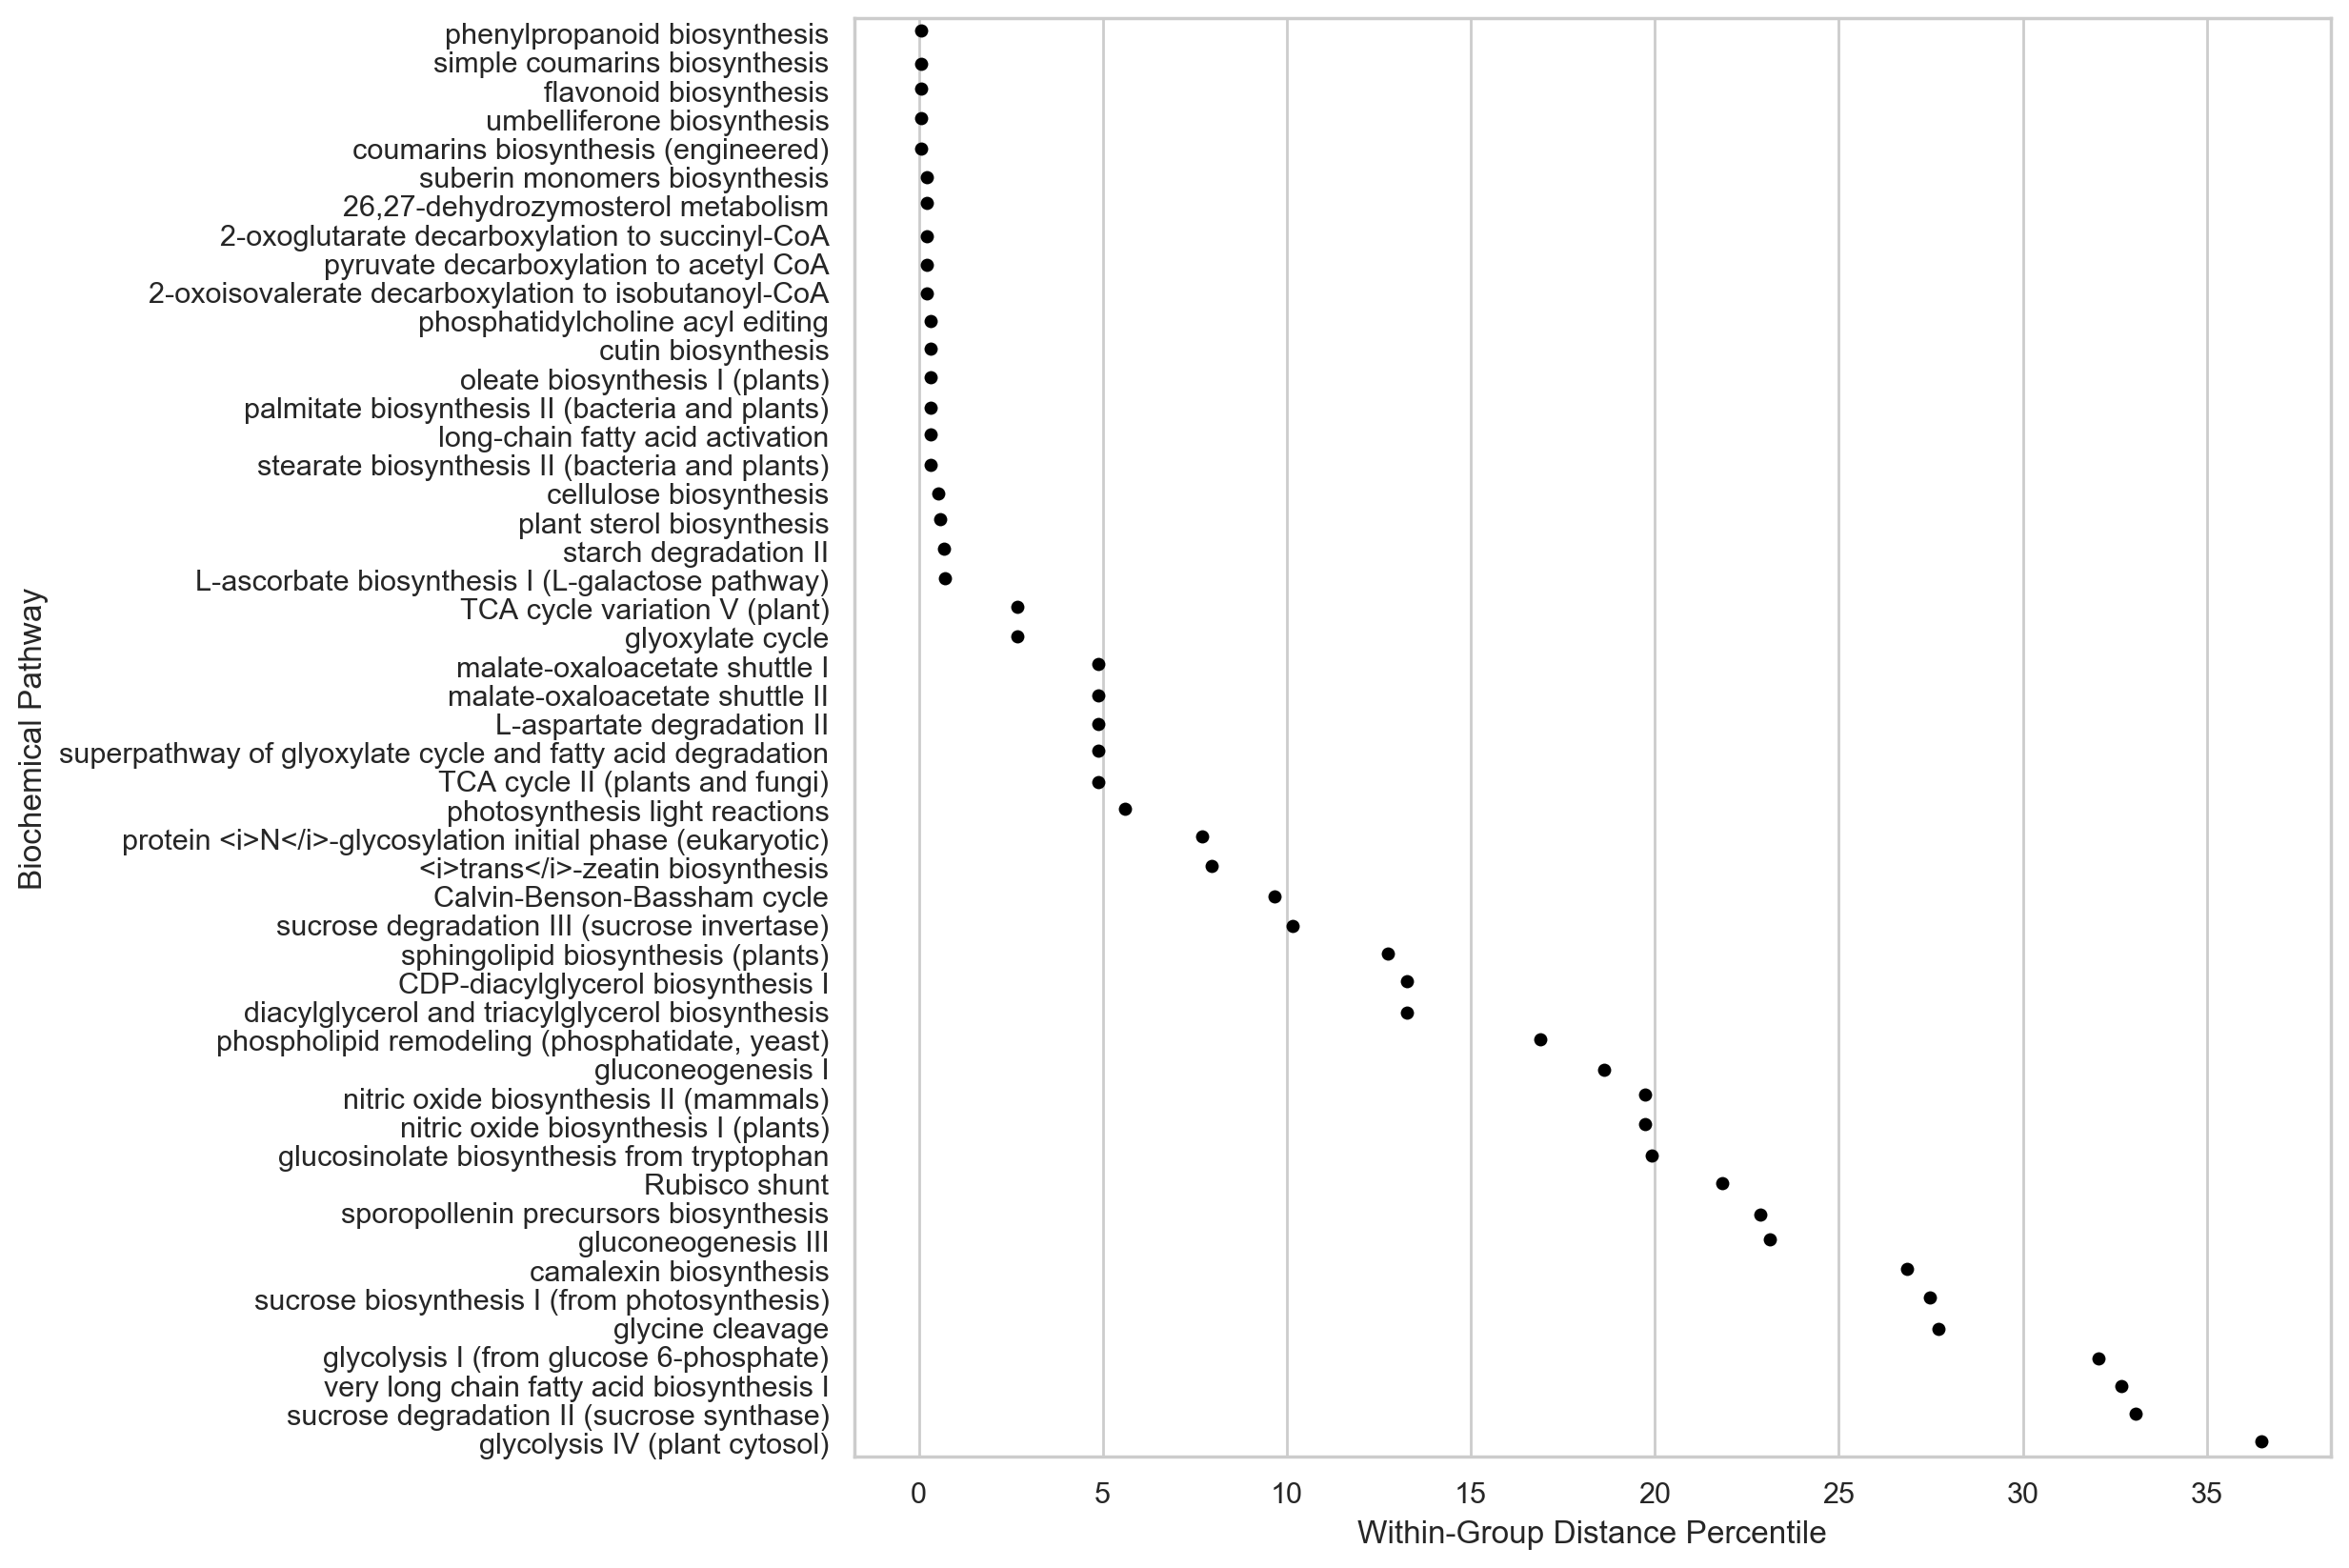

In [22]:
# Which pathways have the most semantic similariy between descriptions associated with their genes?
percentiles.sort_values(by="doc2vec", inplace=True)
sns.set(rc={'figure.figsize':(10,10), "figure.dpi":200})
sns.set(style="whitegrid")
ax = sns.stripplot(y="full_name", x="doc2vec", data=percentiles.head(50), orient="h", color="black")
ax.set(xlabel='Within-Group Distance Percentile', ylabel="Biochemical Pathway")
plt.show()